# 1- Overview

https://www.kaggle.com/c/home-credit-default-risk

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

Inspired by some great kernels:
- sban: https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772
- Will Koehrsen: 
    - https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering 
    - https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- [Aguiar[Updated 0.792 LB] LightGBM with Simple Features](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features/code)
- [Bojan TunguzXGB Simple Features](https://www.kaggle.com/tunguz/xgb-simple-features/code)
- [Ivan TimoshilovFork_LightGBM_with_Simple_Features](https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features)




# 2- About the data

### <font color='green'> Data frames we have are : </font>

#### <font color='purple'> application_{train|test}.csv </font>

* This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

#### <font color='purple'> bureau.csv </font>

* All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### <font color='purple'> bureau_balance.csv </font>

* Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

#### <font color='purple'> POS_CASH_balance.csv </font>

* Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

#### <font color='purple'> credit_card_balance.csv </font>

* Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some 
history observable for the previous credit card) rows.

#### <font color='purple'> previous_application.csv </font>

* All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

#### <font color='purple'> installments_payments.csv</font>

* Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

#### <font color='purple'> HomeCredit_columns_description.csv </font>

* This file contains descriptions for the columns in the various data files.

# 3- Import the Tools we need

In [49]:
#reading data , EDA , preprocessing tool , visualizations
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#impalanced category , train test split , model optimization
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score

#saving the model
import pickle

![Annotation 2021-06-27 024230](https://user-images.githubusercontent.com/59618586/123529529-6121ce80-d6f1-11eb-93e3-ae8588aca8f9.png)


# 4- Read the Data + EDA

In [55]:
df = pd.read_csv('application_train.csv')
df1 = pd.read_csv('application_test.csv')

In [56]:
#correlation
corr_Y = df.corr(method='pearson')["TARGET"].sort_values()
print(corr_Y.head(10),corr_Y.tail(10),sep='\n\n')

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


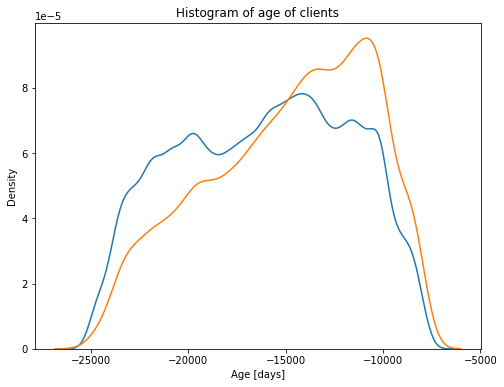

In [57]:
#client age range
plt.figure(figsize = (8,6))
sns.kdeplot(df[df['TARGET']==0]['DAYS_BIRTH'], label = 'Target = 0')
sns.kdeplot(df[df['TARGET']==1]['DAYS_BIRTH'], label = 'Target = 1')
plt.title('Histogram of age of clients')
plt.xlabel('Age [days]')
plt.ylabel('Density')
plt.show()

C:\Users\zd\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


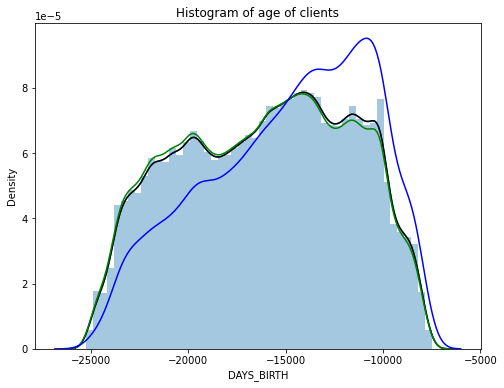

In [60]:
#days birth
plt.figure(figsize=(8,6))
plt.title('Histogram of age of clients')
plt.xlabel('Age [days]')
plt.ylabel('Density')
sns.distplot(df["DAYS_BIRTH"])

sns.kdeplot(df['DAYS_BIRTH'], label = 'Target = 0 & 1',color="black")
sns.kdeplot(df[df['TARGET']==0]['DAYS_BIRTH'], label = 'Target = 0',color="green")
sns.kdeplot(df[df['TARGET']==1]['DAYS_BIRTH'], label = 'Target = 1',color="b")

plt.show();

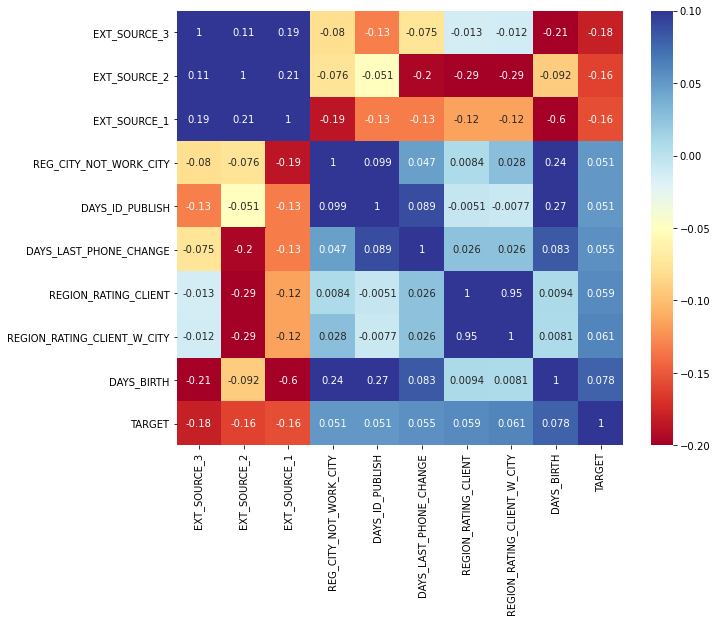

In [62]:
# select only attributes with |corr| > 0.05
indices = corr_Y[abs(corr_Y) > 0.05].index
fea_corr = df[indices].corr()

plt.figure(figsize=(10,8))
sns.heatmap(fea_corr, cmap="RdYlBu", annot=True, vmin=-0.2, vmax=0.1)
plt.show()

In [4]:
# make a label as to whether the instance belongs to train to test dataset
df['is_train'] = 1
df1['is_train'] = 0

# target for train data
trainY = df['TARGET']
df.drop('TARGET',axis=1,inplace=True)


# test id 
testID = df1['SK_ID_CURR']

data = pd.concat([df,df1],axis=0)

In [8]:
#discovering data types
df.dtypes

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
is_train                        int64
Length: 122, dtype: object

In [11]:
#Nan values in each feature percentage
total = df[df.columns[df.isnull().any()==True]]
total.isnull().mean().sort_values(ascending=False)*100

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_AVG     69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
                              ...    
EXT_SOURCE_2                 0.214626
AMT_GOODS_PRICE              0.090403
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64

# 5- preprocessing 

In [12]:
#filling by mode
df['DAYS_EMPLOYED'].replace(df['DAYS_EMPLOYED'].mode()[0], np.nan, inplace= True)

In [13]:
#feature generation also filling Nan values in common df's features
def prepare_df(data):
    data['NEW_CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['NEW_CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['NEW_ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['NEW_CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].median(),inplace=True)
    data['NEW_INC_PER_MEMB'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['NEW_INC_PER_CHLD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])

    data['NEW_EMPLOY_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['NEW_CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    data['NEW_CAR_TO_EMPLOY_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
    data['NEW_PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

    data['NEW_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    data['NEW_EXT_SOURCES_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    data['NEW_SCORES_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    data['NEW_SCORES_STD'].fillna(data['NEW_SCORES_STD'].mean(),inplace=True)
    
    return data

In [14]:
#removing ouliers using IQR(inter quartile range)
def remove_outliers(df):
#     d1 = df.select_dtypes(include='O')
#     df = df.select_dtypes(exclude='O')
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]
#     df = pd.concat([df, d1], axis=1)
    return df

In [15]:
#removing features wo has more than 50% Nan values and filling other features
def process_df(df, raw=False):
    df_nan = df[df.columns[df.isnull().any()]]
    df_na = df_nan[df_nan.columns[df_nan.isnull().mean()*100 < 50]]
    df_not_nan = df[df.columns[~df.isnull().any()]]
    df_na_cat = df_na.select_dtypes(include='O')
    for col in df_na_cat:
        df_na_cat[col].fillna(df_na_cat[col].mode()[0], inplace=True)
    df_na_num = df_na.select_dtypes(exclude='O')
    df_na_num = remove_outliers(df_na_num)
    df_na_num = df_na_num.fillna(df_na_num.mean())
    if raw:
        df = pd.concat([df_not_nan.drop('SK_ID_CURR', axis=1), df_na_cat, df_na_num], axis=1)
    else:
        df = pd.concat([df_not_nan, df_na_cat, df_na_num], axis=1)
    df = pd.get_dummies(df, drop_first=True)
    return df

In [16]:
#lets use our function
data = prepare_df(data)

In [17]:
#read other datasets
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

In [18]:
#labeling STATUS 
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace(['C','X'],'0').apply(lambda x:int(x))
bb = bureau_balance['STATUS'].groupby(bureau_balance['SK_ID_BUREAU']).sum().to_frame()

# merge the sum of DPD
bureau = pd.merge(bureau,bb,left_on='SK_ID_BUREAU',right_index=True,how='left')

In [19]:
#lets process our data
bureau = process_df(bureau)

In [20]:
# examine fraction of missing value in each attribute
def missing_df(df):
        """
        return a data frame containing the statistics of missing value
        """
        
        total = df.isnull().sum().sort_values(ascending=False)
        fraction = 100 * total / df.shape[0]
        
        # keep to two decimal places
        fraction = fraction.apply(lambda x: round(x,2))
        
        df_missing = pd.concat([total,fraction], axis=1, keys=['Total','Fraction'])
        df_missing.index.name = 'Attributes'
        
        return df_missing
    
    
def cut_missing_fea(df, mis_threshold=50):
    """
    cut off features with ratio of missing values bigger than 60%
    """
    missing = missing_df(df)
    keep_fea = missing[missing['Fraction']<mis_threshold].index

    return df[keep_fea]


    
def prepare_data(df, group_var, prefix):
    
    # cut off featues with too much missing values
    df = cut_missing_fea(df)
    
    # if only one or two categories, factorize()
    for col in df:
        if df[col].dtype == 'object' and len(list(df[col].unique())) <= 2:
            df.loc[:,col], _ = pd.factorize(df[col])
    
    # one hot encoding if more than two categories, including Null
    df = pd.get_dummies(df,dummy_na=True)
    
    # compute sum, mean, std for each column
    d1 = df.drop([group_var],axis=1).groupby('SK_ID_CURR').agg(['sum','mean','std'])
    d1.columns = ['_'.join(col).strip('_ ') for col in d1.columns.values]
    d1.add_prefix(prefix+'_')
    
    # count group_var for each SK_ID_CURR
    d2 = df[['SK_ID_CURR',group_var]].groupby('SK_ID_CURR').count()
    
    # merge 
    df = pd.merge(d1,d2,left_index=True,right_index=True,how='left')
    
    # add prefix
    df = df.add_prefix(prefix+'_')
    
    return df.reset_index()
    

In [21]:
#prepare the bureau df with the same prepare function
bureau = prepare_data(bureau,group_var='SK_ID_BUREAU',prefix='bureau')
print("bureau.shape = ",bureau.shape)


# merge with  data
data = pd.merge(data,bureau,how='left')
data.shape

bureau.shape =  (305811, 92)


(356255, 226)

In [22]:
#delete old data from the memory to allocate faster
del bureau, bureau_balance

In [23]:
#read the previous applications data
prev_app = pd.read_csv('previous_application.csv')

In [24]:
#replacing the Nan values with the mode of the days 365243
col_DAYS = []
for col in prev_app:
    if 'DAYS' in col:
        col_DAYS.append(col)

for col in col_DAYS:
    prev_app[col].replace(365243,np.nan,inplace=True)
del col_DAYS

In [25]:
#prepare data with exceptions
prev_app = prepare_data(prev_app,group_var='SK_ID_PREV',prefix='prev_app')

#merging the important data with the "data1"
data1 = pd.merge(data,prev_app,how='left')

C:\Users\zd\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [26]:
#read the cash balance data
pos_bal = pd.read_csv('POS_CASH_balance.csv')

In [27]:
#prepare the cash balance data
pos_bal = prepare_data(pos_bal,group_var='SK_ID_PREV',prefix='pos')

# merge with main work data
data = pd.merge(data,pos_bal,how='left')

In [28]:
#delete the un-needed data to ease the allocation for the memory
del pos_bal, prev_app

In [29]:
#read the install payments dataset
install_pay = pd.read_csv('installments_payments.csv')

In [30]:
#prepare the payments dataset
install_pay = prepare_data(install_pay,group_var='SK_ID_PREV',prefix='install')

# merge with data
data = pd.merge(data,install_pay,how='left')

In [31]:
#read the credit balance dataset
credit_bal = pd.read_csv('credit_card_balance.csv')

In [32]:
#prepare the credit balance dataset
credit_bal = prepare_data(credit_bal,group_var='SK_ID_PREV',prefix='credit')

# merge with data
data = pd.merge(data,credit_bal,how='left')

In [33]:
#delete the un-needed data to ease the allocation for the memory
del credit_bal, install_pay

In [34]:
#data.to_csv("data.csv") #save the prepared work data as .csv file
#data = pd.read_csv('data.csv') #red the work data if it is already saved

In [35]:
# process the wholde data
data = process_df(data, raw=False)

C:\Users\zd\Anaconda3\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# 6- Scaling Data

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [37]:
data.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,0.018801,-9461,-637,-3648.0,-2120,1,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,0.003541,-16765,-1188,-1186.0,-291,1,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,67500.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,0.008019,-19005,-3039,-9833.0,-2437,1,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1,...,0,0,0,0,0,0,0,0,0,0


# 7- dealing with imbalanced target

C:\Users\zd\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


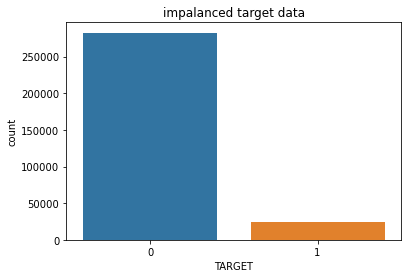

In [39]:
#visualize the imbalaced target label
sns.countplot(trainY);
plt.title("impalanced target data");

In [40]:
#ignoring features we wont need and prepare for modeling
ignore_features = ['SK_ID_CURR', 'is_train']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_train'] == 0][relevant_features]

In [41]:
#another imputations by median
imputer = SimpleImputer(strategy="median")
imputer.fit(trainX)
trainX = imputer.transform(trainX)
testX = imputer.transform(testX)

In [42]:
#dealing with imbalanced by SMOTE
smt = SMOTE()
X_smote_res, y_smote_res = smt.fit_resample(trainX, trainY)

C:\Users\zd\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


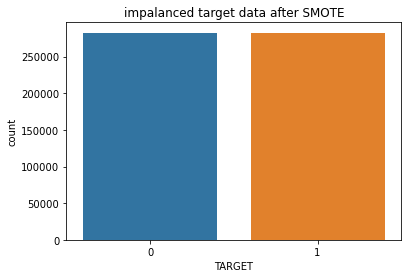

In [44]:
sns.countplot(y_smote_res);
plt.title("impalanced target data after SMOTE");

# 8- splitting data

In [45]:
#train test splits
x_train, x_val, y_train, y_val = train_test_split(X_smote_res, y_smote_res, test_size=0.2, random_state=42)

# 9- training the model and evaluating

In [46]:
#lighGBM model data preparation
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [47]:
#train the model with the hyper-parameters

params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}

model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=100, verbose_eval=20)

C:\Users\zd\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[20]	valid_0's auc: 0.96257
[40]	valid_0's auc: 0.965815
[60]	valid_0's auc: 0.969024
[80]	valid_0's auc: 0.970722
[100]	valid_0's auc: 0.971997
[120]	valid_0's auc: 0.972824
[140]	valid_0's auc: 0.973472
[160]	valid_0's auc: 0.97399
[180]	valid_0's auc: 0.97447
[200]	valid_0's auc: 0.974896
[220]	valid_0's auc: 0.975262
[240]	valid_0's auc: 0.975617
[260]	valid_0's auc: 0.975929
[280]	valid_0's auc: 0.976199
[300]	valid_0's auc: 0.976434
[320]	valid_0's auc: 0.976644
[340]	valid_0's auc: 0.976846
[360]	valid_0's auc: 0.977043
[380]	valid_0's auc: 0.977225
[400]	valid_0's auc: 0.977417
[420]	valid_0's auc: 0.97759
[440]	valid_0's auc: 0.977761
[460]	valid_0's auc: 0.977911
[480]	valid_0's auc: 0.978063
[500]	valid_0's auc: 0.978191
[520]	valid_0's auc: 0.978321
[540]	valid_0's auc: 0.978443
[560]	valid_0's auc: 0.978563
[580]	valid_0's auc: 0.978679
[600]	valid_0's auc: 0.978781
[620]	valid_0's auc: 0.978882
[640]	valid_0's 

In [50]:
#saving the model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [51]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))